# ANN Project

## Importing Library

In [25]:
# !pip install keras-tuner

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,InputLayer,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras_tuner.tuners import RandomSearch, GridSearch
from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras import backend
import random
random.seed(1)
import warnings
warnings.filterwarnings("ignore")

## Loading the data

In [40]:
data = pd.read_csv("/content/drive/MyDrive/DEEP Learning Project/Input Data.csv")

In [85]:
# Checking the number of rows and columns in the data
data.shape

(12597, 2)



*   Dataset has 12597 rows and 2 columns




## Data overview

In [86]:
# Let's view the first 5 rows of the data
data.head(5)

,X,Y
0,12261.2,782.200000
1,12271.2,782.414455
2,12281.2,782.628910
3,12291.2,782.843364
4,12301.2,783.057819


In [87]:
# Let's view the last 5 rows of the data
data.tail(5)

,X,Y
12592,137535.0,2295.533700
12593,137545.0,2295.618689
12594,137555.0,2295.703677
12595,137565.0,2295.788665
12596,137575.0,2295.873654


In [88]:
# Let's check the datatypes of the columns in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12597 entries, 0 to 12596
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       12597 non-null  float64
 1   Y       12597 non-null  float64
dtypes: float64(2)
memory usage: 197.0 KB




* There are  12597 observations and 2 columns in the data.
* All columns has numerical data type.




In [89]:
# Let's check for duplicate values in the data
data.duplicated().sum()

0

In [90]:
# Let's view the statistical summary of the numerical columns in the data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
X,12597.0,74895.214321,36180.124225,12261.2,43557.400000,74887.400000,106230.50000,137575.000000
Y,12597.0,1568.233102,419.278035,782.2,1230.974888,1559.535675,1913.57751,2295.873654


## Univariate Analysis

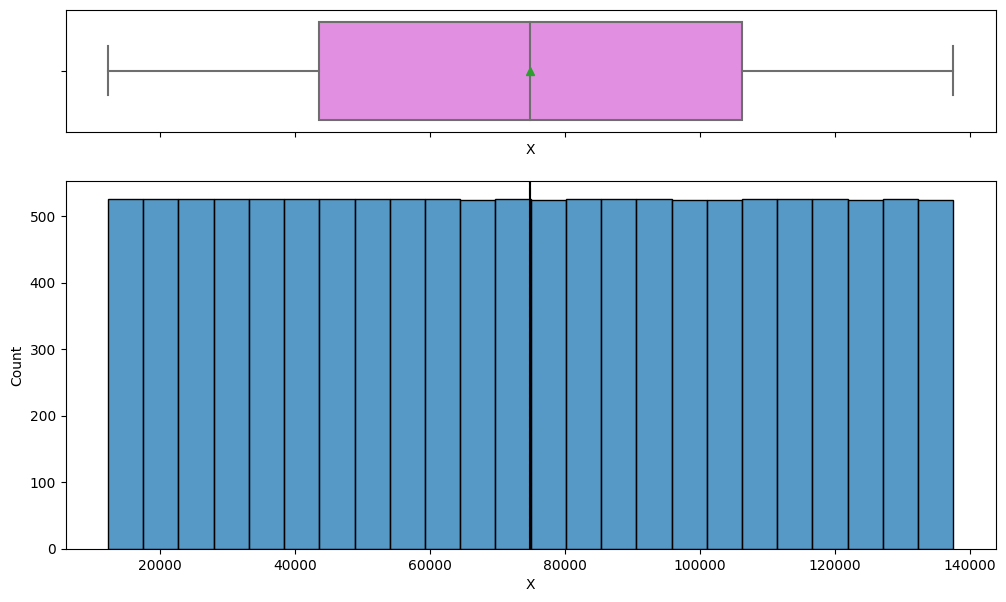

In [91]:
# Function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

histogram_boxplot(data,'X')



*   From the above plot, we observe that there X is uniformaly distributed and has no outlier in that.
* Mean == Median for X



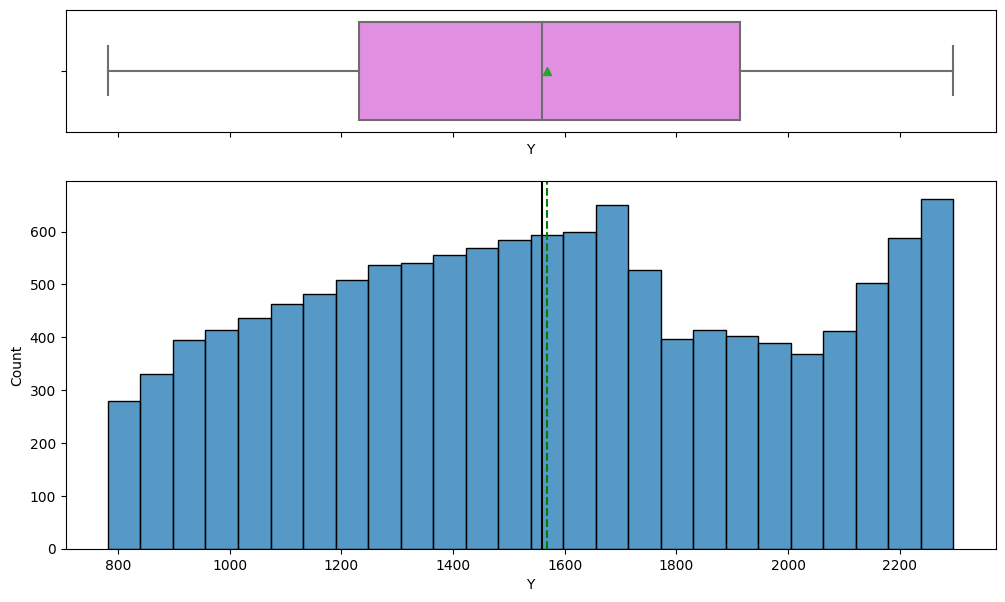

In [92]:
histogram_boxplot(data,"Y")

## Bivarient Analysis

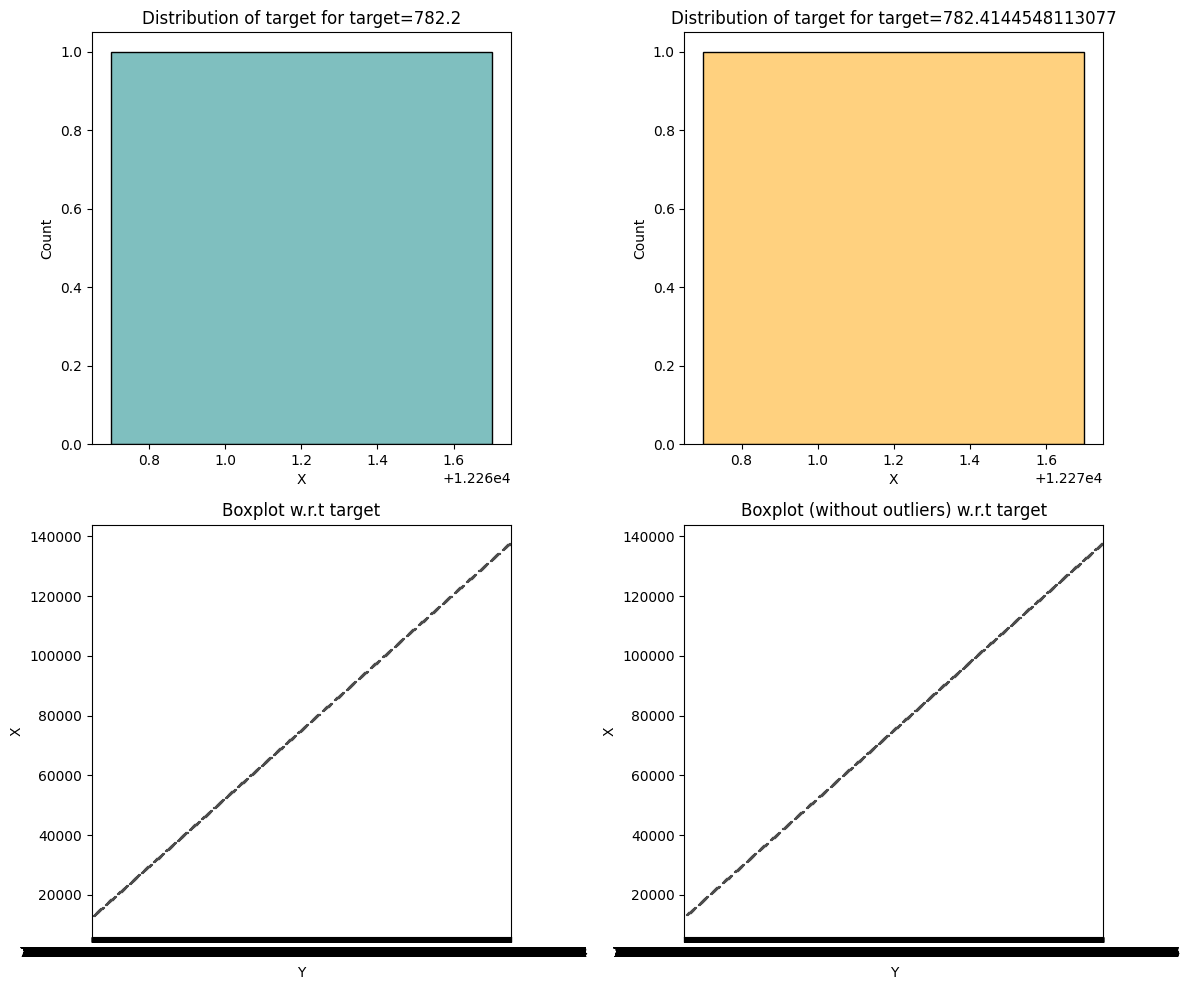

In [93]:
### Function to plot distributions


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()
distribution_plot_wrt_target(data,'X',"Y")



*   From the above plot, it clear that relation between X and Y is aprox. linear (Correlation in between X and Y is positive )




In [106]:
## Check null value in data
data.isnull().sum()

X    0
Y    0
dtype: int64

## Saperating data into input (X)variable and target variable (y)

In [5]:
X,y = data.X,data.Y

## Splitting the dataset into the training and testing set.
In the ratio:
* Training = 90%
* testing = 10%

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 42)

## Reshaping and scaling the datasets

In [41]:
def reshape(X):
  X = np.array(X)
  return X.reshape(-1,1)

X_train = reshape(X_train[:])
X_test = reshape(X_test[:])
def scale_datasets(X_train, X_test):

  """
  Standard Scale test and train data
  Z - Score normalization
  """
  standard_scaler = StandardScaler()
  X_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(X_train)
  )
  X_test_scaled = pd.DataFrame(
      standard_scaler.transform(X_test)
  )
  return X_train_scaled, X_test_scaled
X_train_scaled, X_test_scaled = scale_datasets(X_train, X_test)
X_train_scaled.shape

(11337, 1)

## Model Building

In [8]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [9]:
# Initializing the ANN
model = Sequential()

# This adds the input layer (by specifying input dimension)
model.add(InputLayer(input_shape=X_train.shape[1]))
#Add 1st hidden layer
model.add(Dense(2800, activation='relu',kernel_initializer='normal'))
# Adding the output layer
# Notice that we do not need to specify input dim. 
# we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
# We use the linear function because we want numerical outcomes
model.add(Dense(1, activation = 'linear')) 

In [10]:
# Create optimizer(Adam) with learning rate =0.0616*1.6
# Compile the model with loss function MeanSquaredError()(Because Regression)
model.compile(loss=losses.MeanSquaredError(), optimizer=optimizers.Adam(learning_rate=0.0616*1.6), metrics=['mse','mae']) ### Loss function = MeanSquaredError()


In [11]:
## Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2800)              5600      
                                                                 
 dense_1 (Dense)             (None, 1)                 2801      
                                                                 
Total params: 8,401
Trainable params: 8,401
Non-trainable params: 0
_________________________________________________________________


## Model training

In [12]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='mae',
                            save_weights_only=True, mode='min',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='mae',factor=0.86,patience=2,min_lr=0.00001,model='auto')

callbacks = [checkpoint,reduce_lr]

history = model.fit(X_train_scaled,y_train,epochs=200,validation_split=0.2,batch_size=100,callbacks=callbacks)

Epoch 1/200
89/91 [============================>.] - ETA: 0s - loss: 215002.2500 - mse: 215002.2500 - mae: 235.8199
Epoch 1: saving model to model_weights.h5
91/91 [==============================] - 7s 6ms/step - loss: 211009.7344 - mse: 211009.7344 - mae: 231.8714 - val_loss: 733.2094 - val_mse: 733.2094 - val_mae: 23.4976 - lr: 0.0986
Epoch 2/200
87/91 [===========================>..] - ETA: 0s - loss: 463.9650 - mse: 463.9650 - mae: 17.8488
Epoch 2: saving model to model_weights.h5
91/91 [==============================] - 0s 4ms/step - loss: 459.9051 - mse: 459.9051 - mae: 17.7721 - val_loss: 371.3990 - val_mse: 371.3990 - val_mae: 16.0256 - lr: 0.0986
Epoch 3/200
88/91 [============================>.] - ETA: 0s - loss: 365.4275 - mse: 365.4275 - mae: 15.3651
Epoch 3: saving model to model_weights.h5
91/91 [==============================] - 0s 4ms/step - loss: 364.3888 - mse: 364.3888 - mae: 15.3231 - val_loss: 341.7623 - val_mse: 341.7623 - val_mae: 15.2246 - lr: 0.0986
Epoch 4/200

40/40 [==============================] - 0s 2ms/step - loss: 976808170225664.0000 - mse: 976808170225664.0000 - mae: 28052912.0000


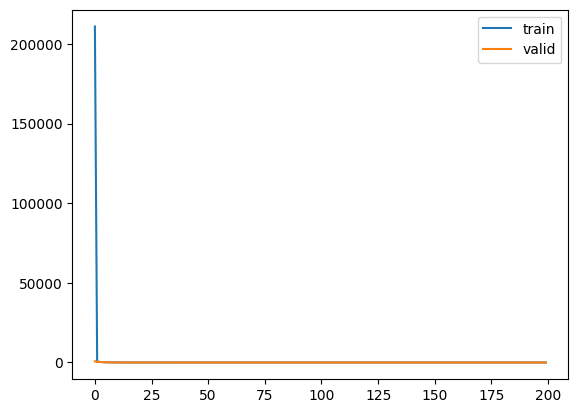

In [13]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#Printing results
results = model.evaluate(X_test, y_test)

## Hyperparameters tunning

In [14]:
def create_model_v5(lr,batch_size):  
  np.random.seed(1337)
  model = Sequential()

  # This adds the input layer (by specifying input dimension)
  model.add(InputLayer(input_shape=X_train.shape[1]))
  #Add 1st hidden layer
  model.add(Dense(3200, activation='relu',kernel_initializer='normal'))
  # Adding the output layer
  # Notice that we do not need to specify input dim. 
  # we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
  # We use the linear function because we want numerical outcomes
  model.add(Dense(1, activation = 'linear')) 
  #compile model
  model.compile(loss=losses.MeanSquaredError(), optimizer=optimizers.Adam(learning_rate=lr), metrics=['mse','mae']) ### Loss function = MeanSquaredError()
  return model

We're using Grid Search to optimize two hyperparameters - **Batch Size** & **Learning Rate**. 

You can also optimize the other hyperparameters as mentioned above.

In [16]:
keras_estimator = KerasRegressor(build_fn=create_model_v5, verbose=1)
# define the grid search parameters
param_grid = {
    'batch_size':[64,32,70,128,3200,2800,5000],
    "lr":[0.8,0.0616*1.7,0.1,0.001],}
# param_grid = {
#     'batch_size':[64,32,70,128,3200,2800,5000],
#     "lr":[0.8,0.0616*1.7,0.1,0.001],"neuron_1":[32,64,128,2000,2500,3200,5000],"kernel_initializer":["normal","he_normal","gorot_uniform","uniform"]}
kfold_splits = 5
grid = GridSearchCV(estimator=keras_estimator,  
                    verbose=1,
                    cv=kfold_splits,  
                    param_grid=param_grid,n_jobs=-1)

In [18]:
import time
  
# store starting time
begin = time.time()
checkpoint = ModelCheckpoint("model_weights.h5",monitor='mae',
                            save_weights_only=True, mode='min',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='mae',factor=0.86,patience=2,min_lr=0.00001,model='auto')

callbacks = [checkpoint,reduce_lr]

grid_result = grid.fit(X_train, y_train,epochs=1,validation_split=0.2,callbacks=callbacks,verbose=1) 

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

time.sleep(1)
# store end time
end = time.time()
  
# total time taken
print(f"Total runtime of the program is {end - begin}")

Fitting 5 folds for each of 28 candidates, totalling 140 fits
114/130 [=========================>....] - ETA: 0s - loss: 2481695.5000 - mse: 2481695.5000 - mae: 850.9438
Epoch 1: saving model to model_weights.h5
130/130 [==============================] - 2s 4ms/step - loss: 2195113.5000 - mse: 2195113.5000 - mae: 780.0162 - val_loss: 94851.5859 - val_mse: 94851.5859 - val_mae: 250.4559 - lr: 0.0010
Best: -96310.467188 using {'batch_size': 70, 'lr': 0.001}
Total runtime of the program is 270.36895537376404


Trial summary
- Hyperparameters:
- number of layers in the model: 1
- number of neurons in layer_0: 3200
- Activation function for layer_0: relu
- Kernel_initializer for layer_0: normal
- Number of units in the output layer: 2
- Activation function for the output layer: linear
- Kernel_initializer for output layer: uniform
- Optimizer for the model: Adam
- Loss for the model: MeanSquaredError
- Model evaluation metric: Mean absolute error/ R2

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.metrics import mean_absolute_error

data = pd.read_csv("/content/drive/MyDrive/DEEP Learning Project/Input Data.csv")
X = data.X
y = data.Y
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=1)
y_train.shape
def reshape(X):
  X = np.array(X)
  return X.reshape(-1,1)

X_train = reshape(X_train[:])
X_test = reshape(X_test[:])
y_train = y_train[:]
def scale_datasets(x_train, x_test):

  """
  Standard Scale test and train data
  Z - Score normalization
  """
  standard_scaler = StandardScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train)
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test)
  )
  return x_train_scaled, x_test_scaled
X_train_scaled, X_test_scaled = scale_datasets(X_train, X_test)
X_train_scaled.shape


# data = pd.read_csv("/content/drive/MyDrive/DEEP Learning Project/Input Data.csv")
# X = data.X
# y = data.Y
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42)
# y_train.shape
# def reshape(X):
#   X = np.array(X)
#   return X.reshape(-1,1)
# def scaling(X):

# X_train_scaled = reshape(X_train_scaled)
# X_test = reshape(X_test_scaled[:])
# y_train = y_train[:]

from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import L1,L2

image_size=X_train.shape[1]

# create model
model = Sequential()  
model.add(InputLayer(input_shape=X_train.shape[1]))
# model.add(BatchNormalization())
model.add(Dense(3200, activation='relu',kernel_initializer='normal')) ###Multiple Dense units with Relu activation
# model.add(Dense(64, activation='relu',kernel_initializer='normal'))
# model.add(Dense(256, activation='relu',kernel_initializer='normal'))
# model.add(BatchNormalization())
# model.add(Dense(128, activation='relu',kernel_initializer='normal'))
# model.add(Dense(64, activation='relu',kernel_initializer='normal'))
# model.add(BatchNormalization())
# model.add(Dense(2000, activation='relu',kernel_initializer='normal'))
# model.add(Dense(128, activation='relu',kernel_initializer='normal'))
# model.add(Dense(256, activation='relu',kernel_initializer='normal'))
# model.add(BatchNormalization())
# model.add(Dense(128, activation='relu',kernel_initializer='normal'))
# model.add(Dense(64, activation='relu',kernel_initializer='normal'))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(64, activation='relu',kernel_initializer='normal'))
# model.add(Dense(5000, activation='relu',kernel_initializer='normal'))
model.add(Dense(1, activation='linear')) ### For multiclass classification Softmax is used 


model.compile(loss=losses.MeanSquaredError(), optimizer=optimizers.Adam(learning_rate=0.0616*1.7), metrics=['mse','mae']) ### Loss function = Categorical cross entropy


checkpoint = ModelCheckpoint("model_weights.h5",monitor='mae',save_weights_only=True, mode='min',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='mae',factor=0.85,patience=2,min_lr=0.00001,model='auto')

callbacks = [checkpoint,reduce_lr]

model.fit(X_train_scaled,y_train,epochs=500,batch_size=68,callbacks=callbacks)

Epoch 1/500
162/167 [============================>.] - ETA: 0s - loss: 108197.2188 - mse: 108197.2188 - mae: 131.3669
Epoch 1: saving model to model_weights.h5
167/167 [==============================] - 1s 3ms/step - loss: 105145.2422 - mse: 105145.2422 - mae: 128.1131 - lr: 0.1047
Epoch 2/500
163/167 [============================>.] - ETA: 0s - loss: 344.3181 - mse: 344.3181 - mae: 14.7859
Epoch 2: saving model to model_weights.h5
167/167 [==============================] - 1s 4ms/step - loss: 343.6282 - mse: 343.6282 - mae: 14.7939 - lr: 0.1047
Epoch 3/500
159/167 [===========================>..] - ETA: 0s - loss: 202.4178 - mse: 202.4178 - mae: 10.8890
Epoch 3: saving model to model_weights.h5
167/167 [==============================] - 1s 3ms/step - loss: 198.3125 - mse: 198.3125 - mae: 10.7590 - lr: 0.1047
Epoch 4/500
161/167 [===========================>..] - ETA: 0s - loss: 90.4385 - mse: 90.4385 - mae: 7.0450
Epoch 4: saving model to model_weights.h5
167/167 [====================




*   Lowest MeanSquaredError = 0.5896
*   and mean absolute error = 0.4004



## Prediction for test 

In [59]:
pre = model.predict(X_test_scaled)

40/40 [==============================] - 0s 1ms/step


## Calculating error range and drawing pie chart for error

In [60]:
a = 0
b = 0
c = 0
d = 0
e = 0
da = []
for i in range(len(y_test)):
  p = pre[i][0]-y_test.iloc[i]
  if -0.1<p<=0.1:
    da.append(0)
    a+=1
  elif -0.2<=p<-0.1 or 0.1<p<=0.2:
    da.append(1)
    b+=1
  elif -1<=p<-0.2 or 0.2<p<=1:
    da.append(2)
    c +=1
  elif -5<=p<-1 or 1<p<=5:
    da.append(3)
    d+=1
  else:
    da.append(4)
    e+=1
Error_1 = (a/(a+b+c+d+e))*100
Error_2 = (b/(a+b+c+d+e))*100
Error_3 = (c/(a+b+c+d+e))*100
Error_4 = (d/(a+b+c+d+e))*100
Error_5 = (e/(a+b+c+d+e))*100
print("Model predict with loss in between -0.1-0.1 is ",Error_1,"%","\nModel predict with loss in between -0.2 to -0.1 and 0.1 to 0.2 is ",Error_2,"%",
      "\nModel predict with loss in between -1 to -0.2 and 0.2 to 1  is ",Error_3,"%","\nModel predict with loss in between -5 to -1 and 1 to 5 is ",Error_4,"%","\nModel predict with loss in between -5> and 5< is ",Error_5,"%")

Model predict with loss in between -0.1-0.1 is  54.12698412698413 % 
Model predict with loss in between -0.2 to -0.1 and 0.1 to 0.2 is  6.746031746031746 % 
Model predict with loss in between -1 to -0.2 and 0.2 to 1  is  25.634920634920633 % 
Model predict with loss in between -5 to -1 and 1 to 5 is  13.015873015873018 % 
Model predict with loss in between -5> and 5< is  0.4761904761904762 %


### Error pie chart



* Error in between -0.1-0.1 == Error_1
* Error in between -0.2 to -0.1 and 0.1 to 0.2. == Error_2
* Error in between -1 to -0.2 and 0.2 to 1 == Error_3
* Error in between -5 to -1 and 1 to 5 == Error_4
* Error in between Other == Error_5




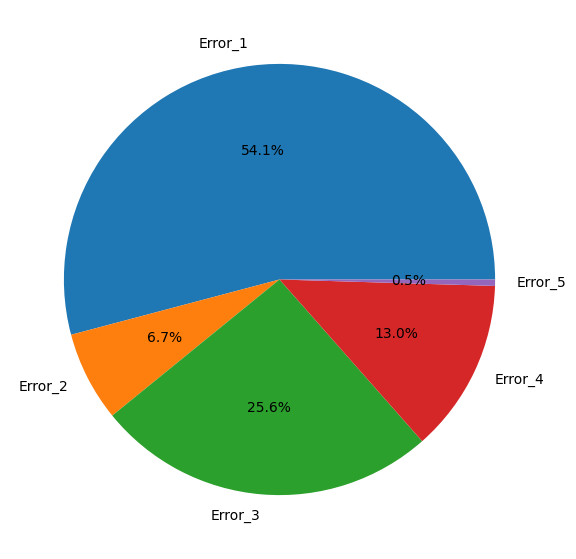

In [61]:
groups = ["Error_1","Error_2","Error_3",'Error_4','Error_5']
per = [Error_1,Error_2,Error_3,Error_4,Error_5]
figure = plt.figure(figsize = (10,7))
plt.pie(per,labels = groups,autopct = "%1.1f%%")
plt.show()